In [12]:
import pandas as pd
import numpy as np
from modules import *
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import word_tokenize
from konlpy.tag import Okt
from nltk.util import everygrams
import matplotlib.pyplot as plt

In [3]:
#원하는 태그 추출 & 불용어 제거
okt = Okt()

#불용어
stopwords = pd.read_csv('ko-stopwords.csv') #한국어불용어사전 불러오기
stopwords=list(stopwords['stopwords']) 
stopwords.extend(['에서','고','이다','는','한','씨', "것","거","게","데","이다","건","고","되다","되어다","걸","기",
                  "시","네","듯","랍니","중이","얘","스","도도", "나","수","개","내","기","제","저","인","있다","이렇다",
                  "그렇다","번","위","팅","분","인","링","란","포","두", "진짜", "하다" ,"이다" ,"가다", "이제" ,"들다",
                 '에서','고','이다','젛','뇨','껀데','뭘'
                 ]) #불용어 추가

stopwords=set(stopwords) # 중복제거    

# 형태소 분석 함수 만들기
def okt_pos_tagging2(string):
    pos_words = okt.pos(string, stem=True, norm=True) # 형태소 분석. 단어는 사전형으로 바꿔주기
    words = [word for word, tag in pos_words if tag 
             in ['Noun', 'Adjective', 'Verb','Adverb'] if word not in stopwords ]

    # n_gram 만들기
    egram = list(everygrams(words, min_len=1, max_len=1))
    egram_token = [' '.join(grams) for grams in egram]

    return egram_token

def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True) # 형태소 분석. 단어는 사전형으로 바꿔주기
    words = [word for word, tag in pos_words if tag 
             in ['Noun', 'Adjective', 'Verb','Adverb'] if word not in stopwords ]

    return words


In [4]:
# 불러올 csv 이름 리스트
# 전체 리뷰를 불러온후 tf-idf 분석
name_list =["막걸리_느린마을","막걸리_복순도가","막걸리_죽향도가"]

In [5]:
all_data = pd.DataFrame()

for name in name_list:
    data = pd.read_csv(f"{name}.csv", encoding='utf-8-sig')
    # 전처리
    data.drop_duplicates(['text'],ignore_index=True, inplace=True) # 중복 제거
    data.columns = ['date', 'star','doc']
    data.doc = data.doc.str.replace("[^가-힣 ]"," ") # 한글만 남기고 특수문자, 숫자, 영어 삭제
    data.doc = data.doc.str.replace("\s+", " ") # white space 삭제
    data.doc = data.doc.str.replace("럽고목","럽고 목")
    data.doc = data.doc.str.replace("부 드럽","부드럽")
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    # globals()["감홍로 40도"] 등으로 데이터 프레임 저장됨
    globals()[f"{name}"] = data
    all_data = pd.concat([all_data,data],axis=0)


C:\Users\user\AppData\Local\Temp\ipykernel_3332\639027951.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data.doc = data.doc.str.replace("[^가-힣 ]"," ") # 한글만 남기고 특수문자, 숫자, 영어 삭제
C:\Users\user\AppData\Local\Temp\ipykernel_3332\639027951.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data.doc = data.doc.str.replace("\s+", " ") # white space 삭제
C:\Users\user\AppData\Local\Temp\ipykernel_3332\639027951.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data.doc = data.doc.str.replace("[^가-힣 ]"," ") # 한글만 남기고 특수문자, 숫자, 영어 삭제
C:\Users\user\AppData\Local\Temp\ipykernel_3332\639027951.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  data.doc = data.doc.str.replace("\s+", " ") # white space 삭제
C:\Users\user\AppData\Local\Temp\ipykernel_3332\639027951.py:8: FutureWarning: The default v

In [6]:
all_data

,date,star,doc
0,2022-11-22,5,원래도 조아래요 배송오니 너무 좋아요
1,2022-11-25,5,자주 주문해서 먹고 있습니다믿고먹는 느린마을내일을 위해 조금 남겨뒀는데남은 것도 잘...
2,2022-11-23,5,밀키스 마시는거 같아요 목넘김이 좋아서 그냥 들어가네요 금방 취합니다
3,2022-10-27,5,우유같은부드러움에 맛도좋고가격도좋고요즘막걸리즐겨마셔요
4,2022-10-25,5,지인분 선물로 보내드렸는데 첨 마셔본건데 너무 맛있다고 만족하셨어요 감사합니다
...,...,...,...
5674,2020-04-03,5,다양한술을 집에서 편하게 주문가능하기에 자주 주문합니다이번에도 즐겁게 마시겠읍니다
5675,2020-04-03,5,빠른 배송 감사합니당
5676,2020-03-31,5,단맛은 있는데 꿀 단맛이어서 나쁘지 않아요 기분 나쁘지 않은 단맛이에요 인공감미료가...
5677,2020-03-26,5,맛이 달고 청량감이 좋아요


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=okt_pos_tagging)
tfidf_fit = tfidf.fit(all_data.doc)


c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
# 특징을 추출할 문서의 tf-idf를 구함
a = "막걸리_느린마을"
bow_rep_tfidf = tfidf_fit.transform(globals()[a].doc)
word_count = pd.DataFrame({
    '단어': tfidf.get_feature_names(),
    'tf-idf': bow_rep_tfidf.sum(axis=0).flat,
    'idf': tfidf.idf_
})


c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
# idf 가 높을수록 잘 안나오는 단어
# tf-idf 가 높을수록 중요한 단어
# 두값을 적절히 조정해서 특징 추출

# word_count.sort_values('tf-idf',ascending=False).head(50)[word_count['idf']>4.9][word_count['tf-idf'] * (len(all_data)/len(globals()[a]))>420]
word_count.sort_values('tf-idf',ascending=False).head(50)

,단어,tf-idf,idf
3042,맛있다,1388.022813,2.013425
7885,좋다,1199.596513,2.367851
3187,먹다,1117.539286,2.447278
2880,막걸리,1040.234030,2.390565
2975,맛,964.858404,2.438450
4133,부드럽다,738.231466,3.426583
3792,배송,705.868719,3.088951
1504,너무,597.757649,2.911349
1699,느리다,528.308054,4.225965
7952,주문,519.670863,3.291878


In [19]:
word_count['단어']

0         가가
1         가감
2         가걱
3         가게
4         가격
        ... 
10128    힘주다
10129     힙하
10130      힛
10131      힝
10132     힝용
Name: 단어, Length: 10133, dtype: object

<AxesSubplot: >

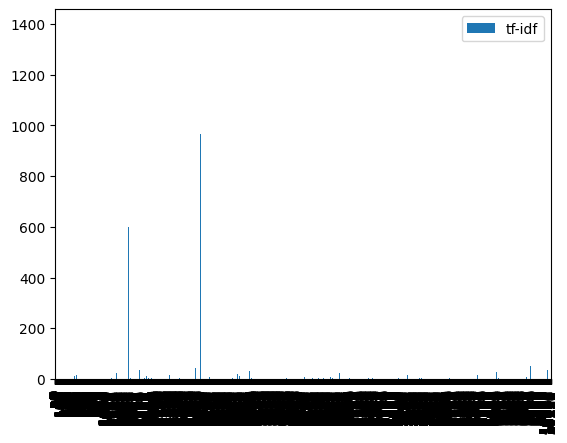

In [20]:
word_count.plot(kind='bar',y=['tf-idf'])